# **Imports**

In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
from glob import glob
import time
import json
from sklearn.model_selection import KFold
import numpy as np
import cv2
import tensorflow as tf
from datetime import datetime 
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# **Variables**

In [2]:
IMAGE_SIZE = (256, 256)

train_files = glob.glob('../input/brain-tumor-segmentation/images/*.png')
mask_files = glob.glob('../input/brain-tumor-segmentation/masks/*.png')

EPOCHS = 80
BATCH_SIZE = 32

# **Data Visualization**

In [3]:
def diagnosis(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": train_files,
                    "mask_path": mask_files,
                    "diagnosis": [diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,../input/brain-tumor-segmentation/images/2664.png,../input/brain-tumor-segmentation/masks/2664.png,1
1,../input/brain-tumor-segmentation/images/2539.png,../input/brain-tumor-segmentation/masks/2539.png,1
2,../input/brain-tumor-segmentation/images/1231.png,../input/brain-tumor-segmentation/masks/1231.png,1
3,../input/brain-tumor-segmentation/images/1017.png,../input/brain-tumor-segmentation/masks/1017.png,1
4,../input/brain-tumor-segmentation/images/2437.png,../input/brain-tumor-segmentation/masks/2437.png,1


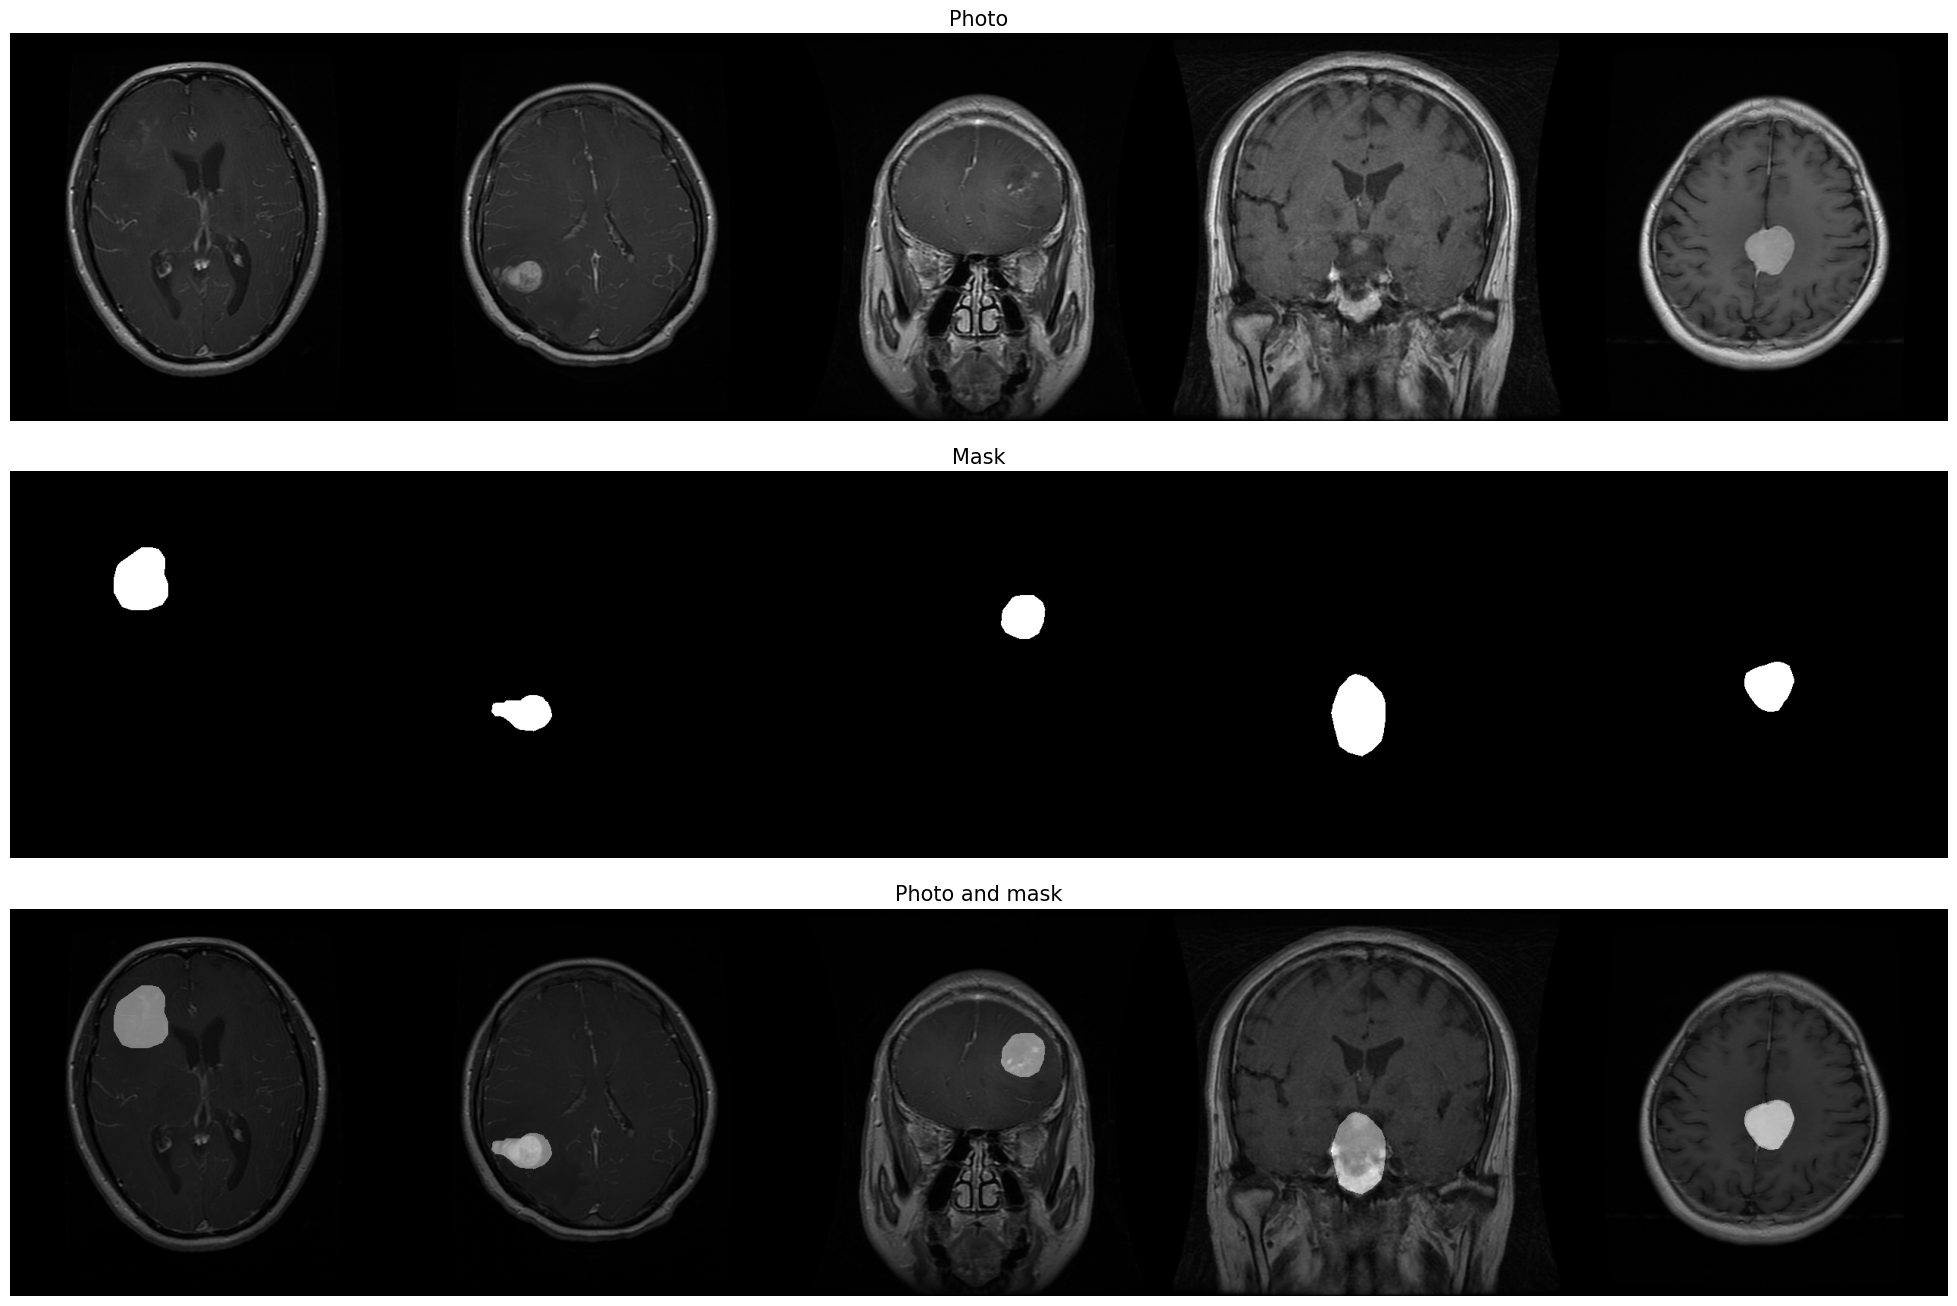

In [4]:
df_positive = df[df['diagnosis']=='1'].sample(5).values

def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = cv2.imread(data[0])
        mask = cv2.imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(25,25))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Photo', fontsize=15)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Mask', fontsize=15)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.4)
        grid[2].set_title('Photo and mask', fontsize=15)
        grid[2].axis('off')
        
show_data(df_positive)

# **Splitting data into train and test** 

In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2213, 3)
(391, 3)
(460, 3)


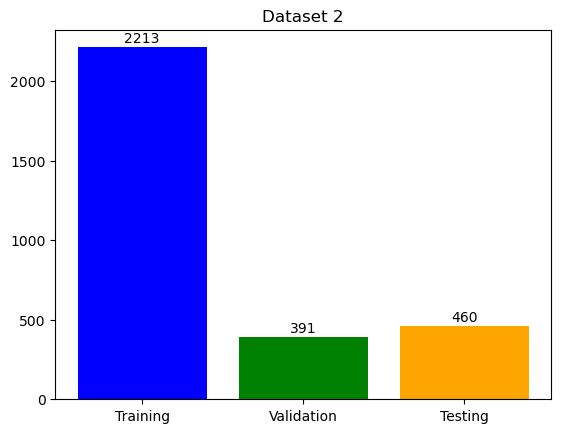

In [6]:
import matplotlib.pyplot as plt
labels = ['Training', 'Validation', 'Testing']
sizes = [2213, 391, 460]
colors = ['blue', 'green', 'orange']
plt.bar(labels, sizes, color=colors)
plt.title('Dataset 2')
for i, v in enumerate(sizes):
    plt.text(i, v + 30, str(v), ha='center')

# Display the plot
plt.show()

# **Data Augmentation & Processing**

In [7]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [8]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE, train_generator_args, target_size=IMAGE_SIZE)

val_gen = train_generator(df_val, BATCH_SIZE, dict(), target_size=IMAGE_SIZE)

test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=IMAGE_SIZE)

# **Dice and IoU Loss Functions**

In [9]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

# **Building Model : UNet**

In [10]:
def conv_block1(inputs, filters):
    x = Conv2D(filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block1(inputs, filters):
    x = conv_block1(inputs, filters)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block1(inputs, filters, concat_layer):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    x = concatenate([x, concat_layer])
    x = conv_block1(x, filters)
    return x

def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block1(inputs, 32)  # Reduce filters in encoder blocks
    s2, p2 = encoder_block1(p1, 64)
    s3, p3 = encoder_block1(p2, 128)
    s4, p4 = encoder_block1(p3, 256)

    b1 = conv_block1(p4, 512)  # Reduce filters in bottleneck block

    d1 = decoder_block1(b1, 256, s4)  # Reduce filters in decoder blocks
    d2 = decoder_block1(d1, 128, s3)
    d3 = decoder_block1(d2, 64, s2)
    d4 = decoder_block1(d3, 32, s1)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(d4)

    unet_model = Model(inputs, outputs, name="UNet")
    return unet_model

unet_model = unet((256, 256, 1))
unet_model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                              

# **Train the Model**

In [11]:
opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
unet_model.compile(optimizer=opt, loss=bce_dice_loss, metrics=["accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet.hdf5', verbose=0, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
             EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

history_unet = unet_model.fit(train_gen,
                              steps_per_epoch=len(df_train) / BATCH_SIZE, 
                              epochs=EPOCHS, 
                              callbacks=callbacks,
                              validation_data=val_gen,
                              validation_steps=len(df_val) / BATCH_SIZE)

Found 2213 validated image filenames.
Found 2213 validated image filenames.
Epoch 1/80


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


70/69 [==============================] - ETA: 0s - loss: 1.3365 - accuracy: 0.9300 - iou: 0.0214 - dice_coef: 0.0419Found 391 validated image filenames.
Found 391 validated image filenames.
69/69 [==============================] - 94s 855ms/step - loss: 1.3365 - accuracy: 0.9300 - iou: 0.0214 - dice_coef: 0.0419 - val_loss: 1.5613 - val_accuracy: 0.9819 - val_iou: 0.0176 - val_dice_coef: 0.0346 - lr: 1.0000e-04
Epoch 2/80
69/69 [==============================] - 49s 715ms/step - loss: 1.1392 - accuracy: 0.9771 - iou: 0.0447 - dice_coef: 0.0853 - val_loss: 1.3646 - val_accuracy: 0.9817 - val_iou: 0.0166 - val_dice_coef: 0.0326 - lr: 1.0000e-04
Epoch 3/80
69/69 [==============================] - 49s 704ms/step - loss: 1.0641 - accuracy: 0.9780 - iou: 0.0651 - dice_coef: 0.1219 - val_loss: 1.2344 - val_accuracy: 0.9826 - val_iou: 0.0158 - val_dice_coef: 0.0312 - lr: 1.0000e-04
Epoch 4/80
69/69 [==============================] - 49s 708ms/step - loss: 1.0323 - accuracy: 0.9783 - iou: 0.074

# **Model Evaluation**

In [12]:
model = load_model('unet.hdf5', custom_objects={'bce_dice_loss': bce_dice_loss, 'accuracy': "accuracy", 'iou': iou, 'dice_coef': dice_coef})
results = unet_model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Loss:", results[0])
print("Accuracy:", results[1])
print("IoU Score:", results[2])
print("Dice Score:", results[3])

Found 460 validated image filenames.
Found 460 validated image filenames.
14/14 [==============================] - 9s 655ms/step - loss: 0.2102 - accuracy: 0.9948 - iou: 0.6900 - dice_coef: 0.8160
Loss: 0.21018537878990173
Accuracy: 0.994759202003479
IoU Score: 0.6900348663330078
Dice Score: 0.8159943222999573


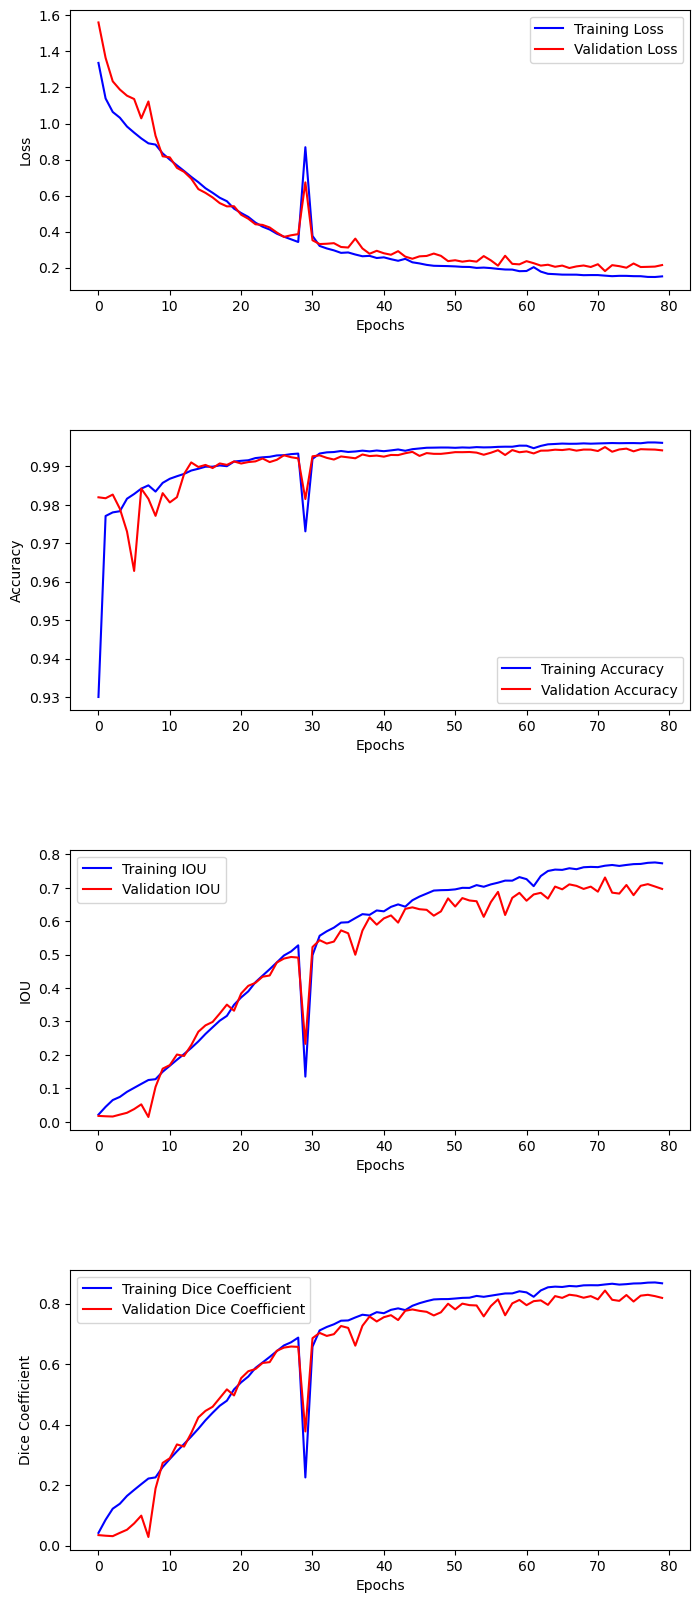

In [13]:
history_dict = history_unet.history
pd.DataFrame.from_dict(history_dict).to_csv('history_unet.csv', index = False)
history_unet_df = pd.read_csv('history_unet.csv')

# Set the height of each subplot
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8, 20))

# Adjust the space between subplots
plt.subplots_adjust(hspace=0.5)

# Plot the loss
axs[0].plot(history_unet_df['loss'], 'b-', label='Training Loss')
axs[0].plot(history_unet_df['val_loss'], 'r-', label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')

# Plot the accuracy
axs[1].plot(history_unet_df['accuracy'], 'b-', label='Training Accuracy')
axs[1].plot(history_unet_df['val_accuracy'], 'r-', label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best')

# Plot the IOU
axs[2].plot(history_unet_df['iou'], 'b-', label='Training IOU')
axs[2].plot(history_unet_df['val_iou'], 'r-', label='Validation IOU')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('IOU')
axs[2].legend(loc='best')

# Plot the dice coefficient
axs[3].plot(history_unet_df['dice_coef'], 'b-', label='Training Dice Coefficient')
axs[3].plot(history_unet_df['val_dice_coef'], 'r-', label='Validation Dice Coefficient')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Dice Coefficient')
axs[3].legend(loc='best')

plt.show()

# **Test the model with an image**

1/1 [==============================] - 1s 1s/step


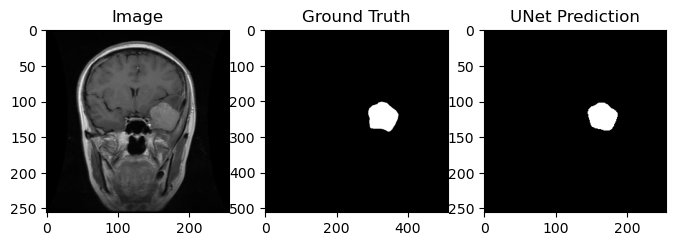

UNet Inference Time: 1360.8215 ms
1/1 [==============================] - 0s 22ms/step


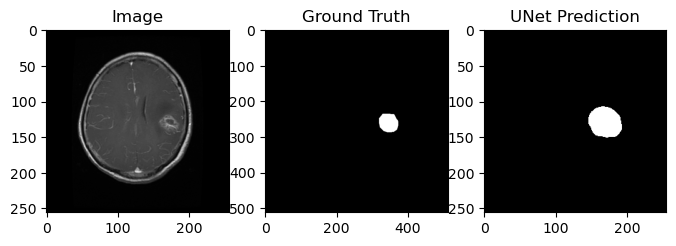

UNet Inference Time: 63.2324 ms
1/1 [==============================] - 0s 20ms/step


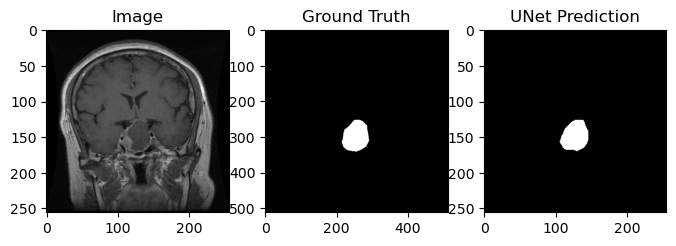

UNet Inference Time: 58.0609 ms
1/1 [==============================] - 0s 20ms/step


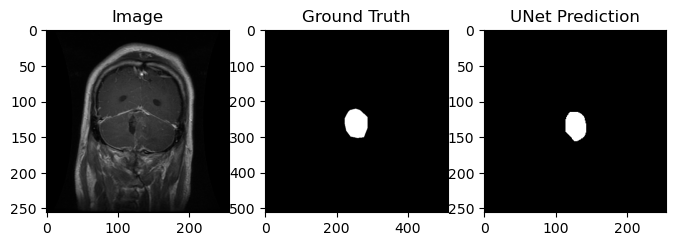

UNet Inference Time: 60.2658 ms
1/1 [==============================] - 0s 20ms/step


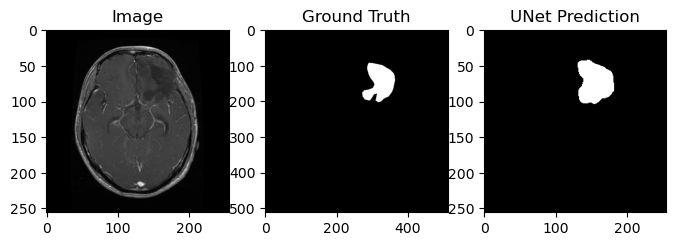

UNet Inference Time: 63.3841 ms
1/1 [==============================] - 0s 22ms/step


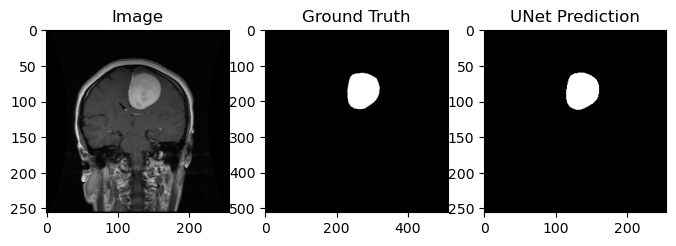

UNet Inference Time: 66.2572 ms
1/1 [==============================] - 0s 21ms/step


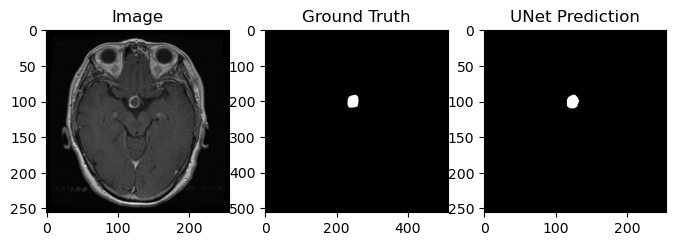

UNet Inference Time: 65.0637 ms
1/1 [==============================] - 0s 20ms/step


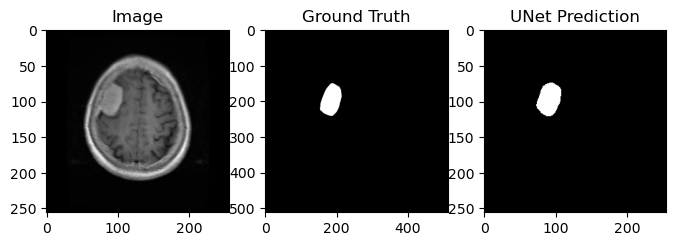

UNet Inference Time: 62.1607 ms
1/1 [==============================] - 0s 21ms/step


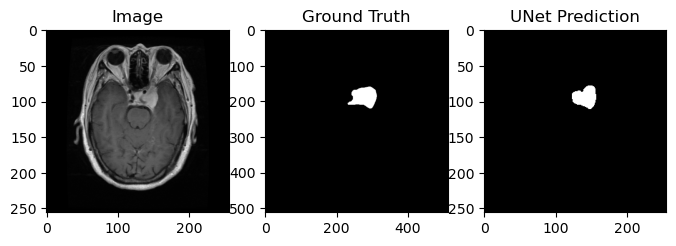

UNet Inference Time: 66.1190 ms
1/1 [==============================] - 0s 20ms/step


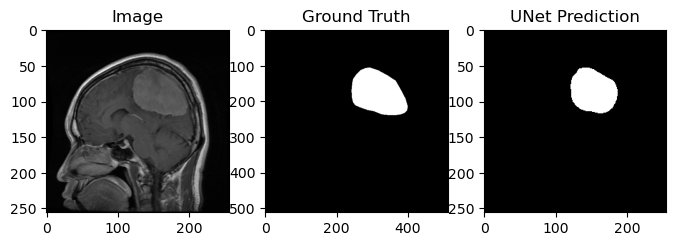

UNet Inference Time: 63.4897 ms


In [14]:
for i in range(10):  
    # Select a random image from the test set
    index = np.random.randint(1, len(df_test.index))

    # Load the image and preprocess it
    img = cv2.imread(df_test['image_path'].iloc[index], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMAGE_SIZE)
    img = img / 255
    img = img[:, :, np.newaxis]
    img = np.expand_dims(img, axis=0)

    # Measure the inference time for UNet
    start_time = time.time()
    pred_unet = unet_model.predict(img)
    end_time = time.time()
    unet_inference_time = (end_time - start_time) * 1000

    # Plot the original image and masks, as well as the predictions
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img), cmap='gray') 
    plt.title('Image')
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])), cmap='gray')  
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_unet) > .5, cmap='gray')  
    plt.title('UNet Prediction')
    plt.show()
    
    # Print the inference time for UNet
    print(f'UNet Inference Time: {unet_inference_time:.4f} ms')


# **Highlighted Tumor**

In [1]:
# Load the model
model_path = '/kaggle/working/unet.hdf5'
model = load_model(model_path, compile=False)

def highlight_tumor(image_path, model):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0  # Normalize the image

    # Expand dimensions to match model input shape
    image = np.expand_dims(image, axis=(0, -1))

    # Perform segmentation
    mask = model.predict(image)

    # Threshold the mask
    threshold = 0.5
    mask_binary = (mask > threshold).astype(np.uint8)

    # Convert the original image to RGB (for visualization purposes)
    original_image_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Resize the mask to match the size of the original image
    highlight_mask_resized = cv2.resize(mask_binary[0], (original_image_rgb.shape[1], original_image_rgb.shape[0]))

    # Create a mask to highlight the tumor region in red
    highlight_mask = cv2.cvtColor(highlight_mask_resized, cv2.COLOR_GRAY2RGB)
    highlight_mask[:, :, 0] = np.where(highlight_mask[:, :, 0] > 0, 255, 0)  # Set red channel to 255 where tumor is present
    highlight_mask[:, :, 1] = 0  # Set green channel to 0
    highlight_mask[:, :, 2] = 0  # Set blue channel to 0

    # Combine the original image with the highlight mask
    highlighted_image = cv2.addWeighted(original_image_rgb, 0.7, highlight_mask, 0.3, 0)

    # Display the highlighted image
    plt.imshow(highlighted_image)
    plt.title('Highlighted Tumor')
    plt.axis('off')
    plt.show()

# Example usage:
image_path = '/kaggle/input/brain-tumor-segmentation/images/4.png'  # Update with the path to your image file
highlight_tumor(image_path, model)

NameError: name 'load_model' is not defined

In [20]:
model.save('model_2.h5')
model.save('my_model_2')

# Step 2: Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('my_model_2')
tflite_model = converter.convert()

# Step 3: Save the TensorFlow Lite model to a file
with tf.io.gfile.GFile('my_model_2.tflite', 'wb') as f:
    f.write(tflite_model)